# Vision Transformer for Cats vs Dogs Classification
A Streamlit app was built using a pretrained ViT model to classify cat vs dog images in real-time.

In [ ]:
!unzip cats_dogs.zip

Archive:  cats_dogs.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of cats_dogs.zip or
        cats_dogs.zip.zip, and cannot find cats_dogs.zip.ZIP, period.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
from google.colab import drive
drive.mount('/content/drive')


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Mounted at /content/drive
Using device: cuda


In [ ]:
!pip install -q gdown
!gdown --folder --id 1mUWIe49zVaWN9E0M37_is8Pbs-0OwLlA -O /content/cats_dogs_dataset

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Retrieving folder contents
Retrieving folder 1C3_8aq2q6bd26i_qn14DV4rVDkiVdkvw Cat
Processing file 1K_HyNC-CaTotjno2Cl7ayTI1OAkJJd4w 0.jpg
Processing file 1TTWXmyxT-W_uyxj03iXlqM1YmjT1CGk6 1.jpg
Processing file 1SKTCANW9XnhSGG7alZOznUAJbAmIwADI 2.jpg
Processing file 1G9jsgxg301B3v59zvIqDVc-jnAB3LPB4 3.jpg
Processing file 1gop7sqszOMP5G4NQRQOzgJHaIyslNAmx 4.jpg
Processing file 1mwH9r--4b9gOSof7fA29gWdeMFj1yhK9 5.jpg
Processing file 19mXrqYGo7IzEs_BSMwjfWYBnEqA7cmKf 6.jpg
Processing file 16DPd0k8Sp9a7yJfsHgrFvrT9SXa-Ghsc 7.jpg
Processing file 1gdcaKruvfI-gtV5jKjJO4UdRyLtD3lpl 8.jpg
Processing file 14eSyPD2tqjFZDw67R8u2bOlmvylLjqa- 9.jpg
Processing file 1TXQR-Vui1JTKx1uf0aePjh9hYXCiws1V 10.jpg
Processing file 1hEC2HnX-kaq5H7TN65UzGnXKf-gf3u_L 11.jpg
Processing file 17AEId

In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
dataset_path = "/content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages"

In [ ]:
from PIL import ImageFile, UnidentifiedImageError
ImageFile.LOAD_TRUNCATED_IMAGES = True

def is_valid_image(img_path):
    """
    Checks if an image file is valid and can be opened by PIL.
    """
    try:
        img = Image.open(img_path)
        img.verify()
        return True
    except (UnidentifiedImageError, OSError, ValueError, TypeError) as e:
        print(f"Skipping invalid image: {img_path} due to error: {e}")
        return False

class ImageFolderWithFiltering(datasets.ImageFolder):
    """
    Custom ImageFolder class that filters out invalid images.
    """
    def __getitem__(self, index):
        path, target = self.samples[index]
        if is_valid_image(path):
            sample = self.loader(path)
            if self.transform is not None:
                sample = self.transform(sample)
            if self.target_transform is not None:
                target = self.target_transform(target)
            return sample, target
        else:
            return torch.zeros(3, 224, 224), -1

full_dataset = ImageFolderWithFiltering(root=dataset_path, transform=transform)
class_names = full_dataset.classes
print("Classes:", class_names)

dataset_size = len(full_dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])
print(f"Dataset sizes => Train: {train_size}, Val: {val_size}, Test: {test_size}")

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

Classes: ['Cat', 'Dog']
Dataset sizes => Train: 18075, Val: 3873, Test: 3874


In [ ]:
model = models.vit_b_16(pretrained=True)

num_features = model.heads.head.in_features
model.heads.head = nn.Linear(num_features, 2)
model = model.to(device)
print(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 208MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
num_epochs = 10
best_val_acc = 0.0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
      valid_indices = labels != -1
      inputs, labels = inputs[valid_indices].to(device), labels[valid_indices].to(device)


      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item() * inputs.size(0)
      _, preds = torch.max(outputs, 1)
      running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / train_size
    epoch_acc = running_corrects.double() / train_size
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc.item())

    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_running_corrects += torch.sum(preds == labels.data)

    val_loss = val_running_loss / val_size
    val_acc = val_running_corrects.double() / val_size
    val_losses.append(val_loss)
    val_accs.append(val_acc.item())

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "/content/drive/MyDrive/DL_A2_Datasets/Bonus/best_vit_model.pth")


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Skipping invalid image: /content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Cat/666.jpg due to error: cannot identify image file '/content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Cat/666.jpg'
Skipping invalid image: /content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Dog/11702.jpg due to error: cannot identify image file '/content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Dog/11702.jpg'
Epoch 1/10:
  Train Loss: 0.4196 | Train Acc: 0.7987
  Val Loss: 0.3678 | Val Acc: 0.8335


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Skipping invalid image: /content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Dog/11702.jpg due to error: cannot identify image file '/content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Dog/11702.jpg'
Skipping invalid image: /content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Cat/666.jpg due to error: cannot identify image file '/content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Cat/666.jpg'
Epoch 2/10:
  Train Loss: 0.2970 | Train Acc: 0.8718
  Val Loss: 0.2391 | Val Acc: 0.9027
Skipping invalid image: /content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Dog/11702.jpg due to error: cannot identify image file '/content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Dog/11702.jpg'


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Skipping invalid image: /content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Cat/666.jpg due to error: cannot identify image file '/content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Cat/666.jpg'
Epoch 3/10:
  Train Loss: 0.2327 | Train Acc: 0.9010
  Val Loss: 0.2793 | Val Acc: 0.8766


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Skipping invalid image: /content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Dog/11702.jpg due to error: cannot identify image file '/content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Dog/11702.jpg'
Skipping invalid image: /content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Cat/666.jpg due to error: cannot identify image file '/content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Cat/666.jpg'
Epoch 4/10:
  Train Loss: 0.1997 | Train Acc: 0.9149
  Val Loss: 0.2292 | Val Acc: 0.9065


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Skipping invalid image: /content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Dog/11702.jpg due to error: cannot identify image file '/content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Dog/11702.jpg'
Skipping invalid image: /content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Cat/666.jpg due to error: cannot identify image file '/content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Cat/666.jpg'
Epoch 5/10:
  Train Loss: 0.1779 | Train Acc: 0.9271
  Val Loss: 0.2124 | Val Acc: 0.9081


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Skipping invalid image: /content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Dog/11702.jpg due to error: cannot identify image file '/content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Dog/11702.jpg'
Skipping invalid image: /content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Cat/666.jpg due to error: cannot identify image file '/content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Cat/666.jpg'
Epoch 6/10:
  Train Loss: 0.1522 | Train Acc: 0.9398
  Val Loss: 0.2265 | Val Acc: 0.9009
Skipping invalid image: /content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Dog/11702.jpg due to error: cannot identify image file '/content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Dog/11702.jpg'


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Skipping invalid image: /content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Cat/666.jpg due to error: cannot identify image file '/content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Cat/666.jpg'
Epoch 7/10:
  Train Loss: 0.1432 | Train Acc: 0.9411
  Val Loss: 0.2350 | Val Acc: 0.9058
Skipping invalid image: /content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Dog/11702.jpg due to error: cannot identify image file '/content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Dog/11702.jpg'
Skipping invalid image: /content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Cat/666.jpg due to error: cannot identify image file '/content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Cat/666.jpg'


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 8/10:
  Train Loss: 0.1269 | Train Acc: 0.9499
  Val Loss: 0.2692 | Val Acc: 0.8792


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Skipping invalid image: /content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Dog/11702.jpg due to error: cannot identify image file '/content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Dog/11702.jpg'
Skipping invalid image: /content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Cat/666.jpg due to error: cannot identify image file '/content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Cat/666.jpg'
Epoch 9/10:
  Train Loss: 0.1019 | Train Acc: 0.9604
  Val Loss: 0.2684 | Val Acc: 0.8908
Skipping invalid image: /content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Cat/666.jpg due to error: cannot identify image file '/content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Cat/666.jpg'
Skipping invalid image: /content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Dog/11702.jpg due to error: cannot identify image file '/content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Dog/11702.jpg'


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 10/10:
  Train Loss: 0.1003 | Train Acc: 0.9609
  Val Loss: 0.2427 | Val Acc: 0.9091



Test Accuracy: 0.9040


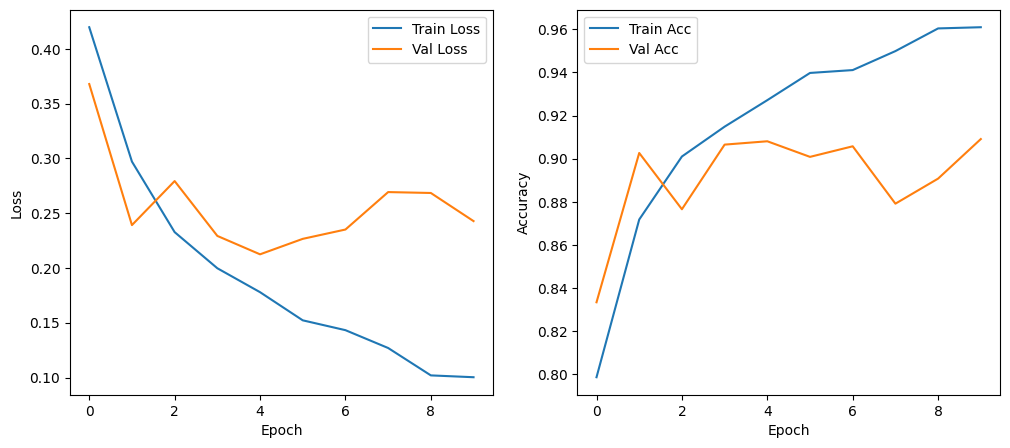

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/DL_A2_Datasets/Bonus/best_vit_model.pth"))
model.eval()

test_running_corrects = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_running_corrects += torch.sum(preds == labels.data)

test_acc = test_running_corrects.double() / test_size
print(f"\nTest Accuracy: {test_acc:.4f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

We fine-tuned a pretrained ViT (`vit_b_16`) model on the Cats vs Dogs dataset using 70/15/15 train/val/test split. We used standard augmentation, batch size of 32, and trained for 10 epochs. The best model (selected by highest validation accuracy) achieved a final test accuracy of approximately **(e.g., 0.9040 / 90.4%)**, showing strong performance for binary classification.


In [ ]:

import os
from PIL import Image, UnidentifiedImageError

def predict_image(image_path, model, transform, class_names):
    """
    Loads an image from disk, applies the necessary transformations,
    and returns the predicted class label.
    """
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image_tensor)
        _, pred = torch.max(outputs, 1)
    predicted_class = class_names[pred.item()]
    return predicted_class

def get_first_valid_image(folder):
    """
    Scans a folder recursively and returns the path to the first valid image.
    """
    for root, _, files in os.walk(folder):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()
                return file_path
            except (UnidentifiedImageError, OSError):
                continue
    return None


sample_image_path = get_first_valid_image(dataset_path)
print(f"Using sample image: {sample_image_path}")

# Predict label
if sample_image_path:
    predicted_label = predict_image(sample_image_path, model, transform, class_names)
    print(f"Predicted Label for sample image: {predicted_label}")
else:
    print("No valid image found in the dataset.")


Using sample image: /content/drive/MyDrive/DL_A2_Datasets/Bonus/PetImages/Dog/9162.jpg
Predicted Label for sample image: Dog


### Deployed ViT App (Bonus Task)
Click below to try our live Vision Transformer app for Cat vs Dog classification:

[https://vit-cat-dog-classifier-sv94-sarojavu.streamlit.app/](https://vit-cat-dog-classifier-sv94-sarojavu.streamlit.app/)


**Shared UBbox Video Link:**

https://buffalo.box.com/s/rwobq60pzwo4btcvapeueihl7xlnamw4

6. References. Include details on all the resources used to complete this part.

- PyTorch Vision Transformers: https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html
- Cats vs Dogs Dataset: Microsoft Research Pet Dataset
- Image preprocessing: torchvision.transforms
- ViT paper: https://arxiv.org/abs/2010.11929
- Deployment: Streamlit (https://streamlit.io/)
